In [1]:
import numpy as np
from scipy.stats import gaussian_kde
from scipy.interpolate import interp1d
from scipy.interpolate import RectBivariateSpline
from scipy.interpolate import UnivariateSpline
import h5py
import os,sys
import astropy.cosmology as cosmo
import astropy.units as u
from astropy.cosmology import Planck15
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import json
import glob
import copy
import re
import pickle

import sys
sys.path.append('/home/thomas.callister/CBC/effective-spin-priors/')
from priors import chi_effective_prior_from_isotropic_spins
from priors import joint_prior_from_isotropic_spins

# Prelim

First, define some helper functions to compute chi_effective and chi_p

In [2]:
def Calculate_Xp(m1, m2, a1, a2, costilt1, costilt2):
    
    q = m2/m1
    sintilt1 = np.sqrt(1-(costilt1)**2)
    sintilt2 = np.sqrt(1-(costilt2)**2)
    
    return np.maximum(a1*sintilt1, (3.+4.*q)/(4.+3.*q)*q*a2*sintilt2)

def Calculate_Xeff(m1, m2, a1, a2, costilt1, costilt2):
    Xeff = (m1*a1*costilt1 + m2*a2*costilt2)/(m1+m2)
    return Xeff

def eta(m1,m2):
    return m1*m2/(m1+m2)/(m1+m2)

def Mc(m1,m2):
    return np.power(eta(m1,m2),3./5.)*(m1+m2)

We'll additionally be reweighting the default LALInference mass and redshift priors with more astrophysically-motivated priors. The LALInference prior is uniform in *luminosity* distance, and uniform in *detector-frame* component masses. This corresponds to:

\begin{equation}
p_\mathrm{lal}(m_1,m_2,z) \propto (1+z)^2 D_L^2(z) \left( D_c(z) + \frac{c(1+z)}{H(z)}\right),
\end{equation}

where $D_L(z)$ and $D_c(z)$ are the luminosity and comoving distance at redshift $z$, respectively, and $H(z)$ is the Hubble parameter at $z$.

We'll reweight to a prior that assumes the (source-frame) comoving merger rate density evolves as $(1+z)^{2.7}$, with a flat prior over *source frame* masses:

\begin{equation}
p_\mathrm{astro}(m_1,m_2,z) \propto \frac{1}{1+z} \left(1+z\right)^{2.7} \frac{dV_c}{dz}
\end{equation}

In [3]:
# Define constants
# Note that we assume a cosmology identical to that in pesummary
c = 299792458 # m/s
H_0 = 67900.0 # m/s/MPc
Omega_M = 0.3065 # unitless
Omega_Lambda = 1.0-Omega_M
year = 365.25*24.*3600

# Construct custom cosmology matching pesummary
cosmo = Planck15.clone(name='cosmo',Om0=Omega_M,H0=H_0/1e3,Tcmb0=0.)

def Hz(z):
    return H_0*np.sqrt(Omega_M*(1.+z)**3.+Omega_Lambda)

def calculate_pLAL(z, dl):
    dc = dl/(1.+z) # comoving distance 
    pLAL = np.power(1.+z,2.)*np.power(dl,2.)*(dc+c*(1.+z)/Hz(z))
    return pLAL

def calculate_pASTRO(z, dl):
    dc = dl/(1.+z) # comoving distance 
    dVc_dz = 4*np.pi*c*(dc**2.)/Hz(z) # comoving volume 
    pASTRO = np.power(1.+z,1.7)*dVc_dz
    return pASTRO

For later use, we'll want to build an interpolant between luminosity distance and redshift:

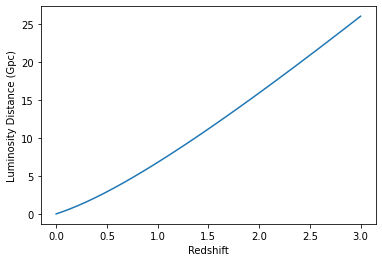

In [4]:
zs_ref = np.linspace(0.,3.,1000)
DL_ref = cosmo.luminosity_distance(zs_ref).to(u.Mpc).value

fig,ax = plt.subplots()
ax.plot(zs_ref,DL_ref/1e3)
ax.set_xlabel('Redshift')
ax.set_ylabel('Luminosity Distance (Gpc)')
plt.show()

Finally, load dictionary we'll use to list events and cut on FAR

In [15]:
eventDict = h5py.File('/home/thomas.callister/CBC/o3b-astro-dist/events.hdf','r')

eventKeyFile = "/home/thomas.callister/CBC/o3b-astro-dist/bin/fetch_o3b_pe_for_rp/event_to_run.json"
with open(eventKeyFile,'r') as jf:
    eventKeyDict = json.load(jf)

target_nSamps = 4000

# O1/O2

In [6]:
O1O2_events = np.array([])

for key in eventDict['O1']:
    O1O2_events = np.append(O1O2_events,str(key))
    
for key in eventDict['O2']:
    if key!='GW170817':
        O1O2_events = np.append(O1O2_events,str(key))
    
print(O1O2_events)

['GW150914' 'GW151012' 'GW151226' 'GW170104' 'GW170608' 'GW170729'
 'GW170809' 'GW170814' 'GW170818' 'GW170823']


In [7]:
for key  in O1O2_events:
    
    print(key)
    
    if os.path.exists("preprocessed-single-events-11-29/{0}.npy".format(key)):
        print("skip")
        continue
    
    # load samples
    BBH_post = h5py.File('/home/shanika.galaudage/O3/population/GWTC-1_sample_release/{0}_GWTC-1.hdf5'.format(key), 'r')['Overall_posterior']
    m1_DF = BBH_post['m1_detector_frame_Msun']
    m2_DF = BBH_post['m2_detector_frame_Msun']
    a1 = BBH_post['spin1']
    a2 = BBH_post['spin2']
    cost1 = BBH_post['costilt1']
    cost2 = BBH_post['costilt2']
    
    Xeff = Calculate_Xeff(m1_DF,m2_DF,a1,a2,cost1,cost2)
    Xp = Calculate_Xp(m1_DF,m2_DF,a1,a2,cost1,cost2)
    DL = BBH_post['luminosity_distance_Mpc']
    
    # Downselect to a reasonable number of samples
    nSamps = min(target_nSamps,Xeff.size)
    sampleDraws = np.random.choice(np.arange(Xeff.size),size=nSamps,replace=False)
    m1_DF = m1_DF[sampleDraws]
    m2_DF = m2_DF[sampleDraws]
    Xeff = Xeff[sampleDraws]
    Xp = Xp[sampleDraws]
    DL = DL[sampleDraws]
    a1 = a1[sampleDraws]
    a2 = a2[sampleDraws]
    cost1 = cost1[sampleDraws]
    cost2 = cost2[sampleDraws]
      
    # Mass ratio
    q = m2_DF/m1_DF

    # Evaluate chi_eff/chi_p priors
    Xeff_priors = np.ones(q.size)
    joint_priors = np.ones(q.size)
    for i in tqdm(range(q.size)):
        joint_priors[i] = joint_prior_from_isotropic_spins(q[i],1.,Xeff[i],Xp[i])
        Xeff_priors[i] = chi_effective_prior_from_isotropic_spins(q[i],1.,Xeff[i])
    print(np.where(np.isnan(joint_priors)))
    print(np.where(joint_priors==0))

    # Redshift and mass priors
    # Note that DL is the observable, and so our mapping to z is model dependent
    z = np.interp(DL,DL_ref,zs_ref)
    Dc = DL/(1.+z)
    pAstro = calculate_pASTRO(z,DL)
    pAstro[pAstro<0] = 0 # if pASTRO < 0, make pASTRO = 0
    p_LAL = calculate_pLAL(z, DL)

    weights = pAstro/p_LAL
    preprocDict = {'Xeff':Xeff,\
                        'Xp':Xp,\
                        'joint_priors':joint_priors,\
                        'Xeff_priors':Xeff_priors,\
                        'weights':weights,\
                        'm1':m1_DF/(1.+z),\
                        'm2':m2_DF/(1.+z),\
                        'a1':a1,\
                        'a2':a2,\
                        'cost1':cost1,\
                        'cost2':cost2,\
                        'z':z
                       }
    
    np.save('preprocessed-single-events-11-29/{0}.npy'.format(key),preprocDict)

GW150914



(array([], dtype=int64),)
(array([], dtype=int64),)
GW151012



(array([], dtype=int64),)
(array([], dtype=int64),)
GW151226



(array([], dtype=int64),)
(array([], dtype=int64),)
GW170104



(array([], dtype=int64),)
(array([], dtype=int64),)
GW170608



(array([], dtype=int64),)
(array([], dtype=int64),)
GW170729



(array([], dtype=int64),)
(array([], dtype=int64),)
GW170809



(array([], dtype=int64),)
(array([], dtype=int64),)
GW170814



(array([], dtype=int64),)
(array([], dtype=int64),)
GW170818



(array([], dtype=int64),)
(array([], dtype=int64),)
GW170823



(array([], dtype=int64),)
(array([], dtype=int64),)


# O3

In [8]:
O3_events = np.array([])

# GW190425 is a BNS
# GW190426, GW200105, and GW200115 are NSBH candidates
# GW190917 is a mass gap event
to_exclude = ['S190425z','S190426c','S190917u','S200105ae','S200115j']
for key in eventDict['O3']:
    if key not in to_exclude:
        
        if key=="%s":
            continue
        
        print(key)
        FAR_in_years = float(eventDict['O3'][key]['FAR']['minfar'].value)*year   
        if FAR_in_years<=1.:
            O3_events = np.append(O3_events,str(key))
    
print(len(O3_events))
print(O3_events)

S190408an
S190412m
S190413ac
S190413i
S190421ar
S190503bf
S190512at
S190513bm
S190517h
S190519bj
S190521g
S190521r
S190527w
S190531n
S190602aq
S190620e
S190630ag
S190701ah
S190706ai
S190707q
S190708ap
S190719an
S190720a
S190725t
S190727h
S190728q
S190731aa
S190803e
S190805bq
S190814bv
S190828j
S190828l
S190910s
S190915ak
S190924h
S190925ad
S190929d
S190930s
S191103a
S191105e
S191109d
S191127p
S191129u
S191204r
S191215w
S191216ap
S191222n
S191230an
S200112r
S200128d
S200129m
S200202ac
S200208q
S200209ab
S200216br
S200219ac
S200224ca
S200225q
S200302c
S200311bg
S200316bj
61
['S190408an' 'S190412m' 'S190413ac' 'S190413i' 'S190421ar' 'S190503bf'
 'S190512at' 'S190513bm' 'S190517h' 'S190519bj' 'S190521g' 'S190521r'
 'S190527w' 'S190531n' 'S190602aq' 'S190620e' 'S190630ag' 'S190701ah'
 'S190706ai' 'S190707q' 'S190708ap' 'S190719an' 'S190720a' 'S190725t'
 'S190727h' 'S190728q' 'S190731aa' 'S190803e' 'S190805bq' 'S190814bv'
 'S190828j' 'S190828l' 'S190910s' 'S190915ak' 'S190924h' 'S190925ad'
 

/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py37/lib/python3.7/site-packages/ipykernel/__main__.py:14: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


In [9]:
for event in O3_events:
    
    hfile = "/home/richard.oshaughnessy/public_html/O3/o3b_snapshots/GWTC-3_2021-11-08_revised/snapshot/{0}.h5".format(event)
    if not os.path.isfile(hfile):
        print("Cannot find file",event)
        continue
        
    if os.path.exists("preprocessed-single-events-11-29/{0}.npy".format(event)):
        print("skip")
        continue
        
    f = h5py.File(hfile,'r')
    print(event)
    print(hfile)
    
    pe_key = eventKeyDict[event]
    print(pe_key)
    BBH_post_samples = f[pe_key]['posterior_samples']
    
    m1_SF = BBH_post_samples['mass_1_source']
    m2_SF = BBH_post_samples['mass_2_source']
    a1 = BBH_post_samples['a_1']
    a2 = BBH_post_samples['a_2']
    cost1 = BBH_post_samples['cos_tilt_1']
    cost2 = BBH_post_samples['cos_tilt_2']
    DL = BBH_post_samples['luminosity_distance']
    z = BBH_post_samples['redshift']
    
    Xeff = Calculate_Xeff(m1_SF,m2_SF,a1,a2,cost1,cost2)
    Xp = Calculate_Xp(m1_SF,m2_SF,a1,a2,cost1,cost2)
            
    # Downselect to a reasonable number of samples
    if event=='S190517h' or event=='S190519bj':
        nSamps = min(8000,Xeff.size)
    else:
        nSamps = min(target_nSamps,Xeff.size)
    print(nSamps)
        
    sampleDraws = np.random.choice(np.arange(Xeff.size),size=nSamps,replace=False)
    m1_SF = m1_SF[sampleDraws]
    m2_SF = m2_SF[sampleDraws]
    Xeff = Xeff[sampleDraws]
    Xp = Xp[sampleDraws]
    DL = DL[sampleDraws]
    z = z[sampleDraws]
    a1 = a1[sampleDraws]
    a2 = a2[sampleDraws]
    cost1 = cost1[sampleDraws]
    cost2 = cost2[sampleDraws]
    
    # Mass ratio
    q = m2_SF/m1_SF
    
    Xeff_priors = np.ones(q.size)
    joint_priors = np.ones(q.size)
    for i in tqdm(range(q.size)):
        joint_priors[i] = joint_prior_from_isotropic_spins(q[i],1.,Xeff[i],Xp[i])
        Xeff_priors[i] = chi_effective_prior_from_isotropic_spins(q[i],1.,Xeff[i])
    print(np.where(np.isnan(joint_priors)))
    print(np.where(joint_priors==0))

    # Redshift and mass priors
    Dc = DL/(1.+z)
    pAstro = calculate_pASTRO(z,DL)
    pAstro[pAstro<0] = 0 # if pASTRO < 0, make pASTRO = 0
    p_LAL = calculate_pLAL(z, DL)

    weights = pAstro/p_LAL    
    
    preprocDict = {'Xeff':Xeff,\
                        'Xp':Xp,\
                        'joint_priors':joint_priors,\
                        'Xeff_priors':Xeff_priors,\
                        'weights':weights,\
                        'm1':m1_SF,\
                        'm2':m2_SF,\
                        'a1':a1,\
                        'a2':a2,\
                        'cost1':cost1,\
                        'cost2':cost2,\
                        'z':z
                       }
    np.save('preprocessed-single-events-11-29/{0}.npy'.format(event),preprocDict)

S190408an
/home/richard.oshaughnessy/public_html/O3/o3b_snapshots/GWTC-3_2021-11-08_revised/snapshot/S190408an.h5
PrecessingSpinIMRHM
4000



(array([], dtype=int64),)
(array([], dtype=int64),)
S190412m
/home/richard.oshaughnessy/public_html/O3/o3b_snapshots/GWTC-3_2021-11-08_revised/snapshot/S190412m.h5
PrecessingSpinIMRHM
4000



(array([], dtype=int64),)
(array([], dtype=int64),)
S190413ac
/home/richard.oshaughnessy/public_html/O3/o3b_snapshots/GWTC-3_2021-11-08_revised/snapshot/S190413ac.h5
PrecessingSpinIMRHM
4000



(array([], dtype=int64),)
(array([], dtype=int64),)
S190413i
/home/richard.oshaughnessy/public_html/O3/o3b_snapshots/GWTC-3_2021-11-08_revised/snapshot/S190413i.h5
PrecessingSpinIMRHM
4000



(array([], dtype=int64),)
(array([], dtype=int64),)
S190421ar
/home/richard.oshaughnessy/public_html/O3/o3b_snapshots/GWTC-3_2021-11-08_revised/snapshot/S190421ar.h5
PrecessingSpinIMRHM
4000



(array([], dtype=int64),)
(array([], dtype=int64),)
S190503bf
/home/richard.oshaughnessy/public_html/O3/o3b_snapshots/GWTC-3_2021-11-08_revised/snapshot/S190503bf.h5
PrecessingSpinIMRHM
4000



(array([], dtype=int64),)
(array([], dtype=int64),)
S190512at
/home/richard.oshaughnessy/public_html/O3/o3b_snapshots/GWTC-3_2021-11-08_revised/snapshot/S190512at.h5
PrecessingSpinIMRHM
4000



(array([], dtype=int64),)
(array([], dtype=int64),)
S190513bm
/home/richard.oshaughnessy/public_html/O3/o3b_snapshots/GWTC-3_2021-11-08_revised/snapshot/S190513bm.h5
PrecessingSpinIMRHM
4000



(array([], dtype=int64),)
(array([], dtype=int64),)
S190517h
/home/richard.oshaughnessy/public_html/O3/o3b_snapshots/GWTC-3_2021-11-08_revised/snapshot/S190517h.h5
PrecessingSpinIMRHM
8000



(array([], dtype=int64),)
(array([], dtype=int64),)
S190519bj
/home/richard.oshaughnessy/public_html/O3/o3b_snapshots/GWTC-3_2021-11-08_revised/snapshot/S190519bj.h5
PrecessingSpinIMRHM
8000



(array([], dtype=int64),)
(array([], dtype=int64),)
S190521g
/home/richard.oshaughnessy/public_html/O3/o3b_snapshots/GWTC-3_2021-11-08_revised/snapshot/S190521g.h5
PrecessingSpinIMRHM
4000



(array([], dtype=int64),)
(array([], dtype=int64),)
S190521r
/home/richard.oshaughnessy/public_html/O3/o3b_snapshots/GWTC-3_2021-11-08_revised/snapshot/S190521r.h5
PrecessingSpinIMRHM
4000



(array([], dtype=int64),)
(array([], dtype=int64),)
S190527w
/home/richard.oshaughnessy/public_html/O3/o3b_snapshots/GWTC-3_2021-11-08_revised/snapshot/S190527w.h5
PrecessingSpinIMRHM
4000



(array([], dtype=int64),)
(array([], dtype=int64),)
Cannot find file S190531n
S190602aq
/home/richard.oshaughnessy/public_html/O3/o3b_snapshots/GWTC-3_2021-11-08_revised/snapshot/S190602aq.h5
PrecessingSpinIMRHM
4000



(array([], dtype=int64),)
(array([], dtype=int64),)
S190620e
/home/richard.oshaughnessy/public_html/O3/o3b_snapshots/GWTC-3_2021-11-08_revised/snapshot/S190620e.h5
PrecessingSpinIMRHM
4000



(array([], dtype=int64),)
(array([], dtype=int64),)
S190630ag
/home/richard.oshaughnessy/public_html/O3/o3b_snapshots/GWTC-3_2021-11-08_revised/snapshot/S190630ag.h5
PrecessingSpinIMRHM
4000



(array([], dtype=int64),)
(array([], dtype=int64),)
S190701ah
/home/richard.oshaughnessy/public_html/O3/o3b_snapshots/GWTC-3_2021-11-08_revised/snapshot/S190701ah.h5
PrecessingSpinIMRHM
4000



(array([], dtype=int64),)
(array([], dtype=int64),)
S190706ai
/home/richard.oshaughnessy/public_html/O3/o3b_snapshots/GWTC-3_2021-11-08_revised/snapshot/S190706ai.h5
PrecessingSpinIMRHM
4000



(array([], dtype=int64),)
(array([], dtype=int64),)
S190707q
/home/richard.oshaughnessy/public_html/O3/o3b_snapshots/GWTC-3_2021-11-08_revised/snapshot/S190707q.h5
PrecessingSpinIMRHM
4000



(array([], dtype=int64),)
(array([], dtype=int64),)
S190708ap
/home/richard.oshaughnessy/public_html/O3/o3b_snapshots/GWTC-3_2021-11-08_revised/snapshot/S190708ap.h5
PrecessingSpinIMRHM
4000



(array([], dtype=int64),)
(array([], dtype=int64),)
S190719an
/home/richard.oshaughnessy/public_html/O3/o3b_snapshots/GWTC-3_2021-11-08_revised/snapshot/S190719an.h5
PrecessingSpinIMRHM
4000



(array([], dtype=int64),)
(array([], dtype=int64),)
S190720a
/home/richard.oshaughnessy/public_html/O3/o3b_snapshots/GWTC-3_2021-11-08_revised/snapshot/S190720a.h5
PrecessingSpinIMRHM
4000



(array([], dtype=int64),)
(array([], dtype=int64),)
S190725t
/home/richard.oshaughnessy/public_html/O3/o3b_snapshots/GWTC-3_2021-11-08_revised/snapshot/S190725t.h5
PrecessingSpinIMRHM
4000



(array([], dtype=int64),)
(array([], dtype=int64),)
S190727h
/home/richard.oshaughnessy/public_html/O3/o3b_snapshots/GWTC-3_2021-11-08_revised/snapshot/S190727h.h5
PrecessingSpinIMRHM
4000



(array([], dtype=int64),)
(array([], dtype=int64),)
S190728q
/home/richard.oshaughnessy/public_html/O3/o3b_snapshots/GWTC-3_2021-11-08_revised/snapshot/S190728q.h5
PrecessingSpinIMRHM
4000



(array([], dtype=int64),)
(array([], dtype=int64),)
S190731aa
/home/richard.oshaughnessy/public_html/O3/o3b_snapshots/GWTC-3_2021-11-08_revised/snapshot/S190731aa.h5
PrecessingSpinIMRHM
4000



(array([], dtype=int64),)
(array([], dtype=int64),)
S190803e
/home/richard.oshaughnessy/public_html/O3/o3b_snapshots/GWTC-3_2021-11-08_revised/snapshot/S190803e.h5
PrecessingSpinIMRHM
4000



(array([], dtype=int64),)
(array([], dtype=int64),)
S190805bq
/home/richard.oshaughnessy/public_html/O3/o3b_snapshots/GWTC-3_2021-11-08_revised/snapshot/S190805bq.h5
PrecessingSpinIMRHM
4000



(array([], dtype=int64),)
(array([], dtype=int64),)
S190814bv
/home/richard.oshaughnessy/public_html/O3/o3b_snapshots/GWTC-3_2021-11-08_revised/snapshot/S190814bv.h5
PrecessingSpinIMRHM
4000



(array([], dtype=int64),)
(array([], dtype=int64),)
S190828j
/home/richard.oshaughnessy/public_html/O3/o3b_snapshots/GWTC-3_2021-11-08_revised/snapshot/S190828j.h5
PrecessingSpinIMRHM
4000



(array([], dtype=int64),)
(array([], dtype=int64),)
S190828l
/home/richard.oshaughnessy/public_html/O3/o3b_snapshots/GWTC-3_2021-11-08_revised/snapshot/S190828l.h5
PrecessingSpinIMRHM
4000



(array([], dtype=int64),)
(array([], dtype=int64),)
S190910s
/home/richard.oshaughnessy/public_html/O3/o3b_snapshots/GWTC-3_2021-11-08_revised/snapshot/S190910s.h5
PrecessingSpinIMRHM
4000



(array([], dtype=int64),)
(array([], dtype=int64),)
S190915ak
/home/richard.oshaughnessy/public_html/O3/o3b_snapshots/GWTC-3_2021-11-08_revised/snapshot/S190915ak.h5
PrecessingSpinIMRHM
4000



(array([], dtype=int64),)
(array([], dtype=int64),)
S190924h
/home/richard.oshaughnessy/public_html/O3/o3b_snapshots/GWTC-3_2021-11-08_revised/snapshot/S190924h.h5
PrecessingSpinIMRHM
4000



(array([], dtype=int64),)
(array([], dtype=int64),)
S190925ad
/home/richard.oshaughnessy/public_html/O3/o3b_snapshots/GWTC-3_2021-11-08_revised/snapshot/S190925ad.h5
PrecessingSpinIMRHM
4000



(array([], dtype=int64),)
(array([], dtype=int64),)
S190929d
/home/richard.oshaughnessy/public_html/O3/o3b_snapshots/GWTC-3_2021-11-08_revised/snapshot/S190929d.h5
PrecessingSpinIMRHM
4000



(array([], dtype=int64),)
(array([], dtype=int64),)
S190930s
/home/richard.oshaughnessy/public_html/O3/o3b_snapshots/GWTC-3_2021-11-08_revised/snapshot/S190930s.h5
PrecessingSpinIMRHM
4000



(array([], dtype=int64),)
(array([], dtype=int64),)
S191103a
/home/richard.oshaughnessy/public_html/O3/o3b_snapshots/GWTC-3_2021-11-08_revised/snapshot/S191103a.h5
C01:Mixed
4000



(array([], dtype=int64),)
(array([], dtype=int64),)
S191105e
/home/richard.oshaughnessy/public_html/O3/o3b_snapshots/GWTC-3_2021-11-08_revised/snapshot/S191105e.h5
C01:Mixed
4000



(array([], dtype=int64),)
(array([], dtype=int64),)
S191109d
/home/richard.oshaughnessy/public_html/O3/o3b_snapshots/GWTC-3_2021-11-08_revised/snapshot/S191109d.h5
C01:Mixed
4000



(array([], dtype=int64),)
(array([], dtype=int64),)
S191127p
/home/richard.oshaughnessy/public_html/O3/o3b_snapshots/GWTC-3_2021-11-08_revised/snapshot/S191127p.h5
C01:Mixed
4000



(array([], dtype=int64),)
(array([], dtype=int64),)
S191129u
/home/richard.oshaughnessy/public_html/O3/o3b_snapshots/GWTC-3_2021-11-08_revised/snapshot/S191129u.h5
C01:Mixed
4000



(array([], dtype=int64),)
(array([], dtype=int64),)
S191204r
/home/richard.oshaughnessy/public_html/O3/o3b_snapshots/GWTC-3_2021-11-08_revised/snapshot/S191204r.h5
C01:Mixed
4000



(array([], dtype=int64),)
(array([], dtype=int64),)
S191215w
/home/richard.oshaughnessy/public_html/O3/o3b_snapshots/GWTC-3_2021-11-08_revised/snapshot/S191215w.h5
C01:Mixed
4000



(array([], dtype=int64),)
(array([], dtype=int64),)
S191216ap
/home/richard.oshaughnessy/public_html/O3/o3b_snapshots/GWTC-3_2021-11-08_revised/snapshot/S191216ap.h5
C01:Mixed
4000



(array([], dtype=int64),)
(array([], dtype=int64),)
S191222n
/home/richard.oshaughnessy/public_html/O3/o3b_snapshots/GWTC-3_2021-11-08_revised/snapshot/S191222n.h5
C01:Mixed
4000



(array([], dtype=int64),)
(array([], dtype=int64),)
S191230an
/home/richard.oshaughnessy/public_html/O3/o3b_snapshots/GWTC-3_2021-11-08_revised/snapshot/S191230an.h5
C01:Mixed
4000



(array([], dtype=int64),)
(array([], dtype=int64),)
S200112r
/home/richard.oshaughnessy/public_html/O3/o3b_snapshots/GWTC-3_2021-11-08_revised/snapshot/S200112r.h5
C01:Mixed
4000



(array([], dtype=int64),)
(array([], dtype=int64),)
S200128d
/home/richard.oshaughnessy/public_html/O3/o3b_snapshots/GWTC-3_2021-11-08_revised/snapshot/S200128d.h5
C01:Mixed
4000



(array([], dtype=int64),)
(array([], dtype=int64),)
S200129m
/home/richard.oshaughnessy/public_html/O3/o3b_snapshots/GWTC-3_2021-11-08_revised/snapshot/S200129m.h5
C01:Mixed
3194



(array([], dtype=int64),)
(array([], dtype=int64),)
S200202ac
/home/richard.oshaughnessy/public_html/O3/o3b_snapshots/GWTC-3_2021-11-08_revised/snapshot/S200202ac.h5
C01:Mixed
4000



(array([], dtype=int64),)
(array([], dtype=int64),)
S200208q
/home/richard.oshaughnessy/public_html/O3/o3b_snapshots/GWTC-3_2021-11-08_revised/snapshot/S200208q.h5
C01:Mixed
4000



(array([], dtype=int64),)
(array([], dtype=int64),)
S200209ab
/home/richard.oshaughnessy/public_html/O3/o3b_snapshots/GWTC-3_2021-11-08_revised/snapshot/S200209ab.h5
C01:Mixed
4000



(array([], dtype=int64),)
(array([], dtype=int64),)
S200216br
/home/richard.oshaughnessy/public_html/O3/o3b_snapshots/GWTC-3_2021-11-08_revised/snapshot/S200216br.h5
C01:Mixed
4000



(array([], dtype=int64),)
(array([], dtype=int64),)
S200219ac
/home/richard.oshaughnessy/public_html/O3/o3b_snapshots/GWTC-3_2021-11-08_revised/snapshot/S200219ac.h5
C01:Mixed
4000



(array([], dtype=int64),)
(array([], dtype=int64),)
S200224ca
/home/richard.oshaughnessy/public_html/O3/o3b_snapshots/GWTC-3_2021-11-08_revised/snapshot/S200224ca.h5
C01:Mixed
4000



(array([], dtype=int64),)
(array([], dtype=int64),)
S200225q
/home/richard.oshaughnessy/public_html/O3/o3b_snapshots/GWTC-3_2021-11-08_revised/snapshot/S200225q.h5
C01:Mixed
4000



(array([], dtype=int64),)
(array([], dtype=int64),)
S200302c
/home/richard.oshaughnessy/public_html/O3/o3b_snapshots/GWTC-3_2021-11-08_revised/snapshot/S200302c.h5
C01:Mixed
4000



(array([], dtype=int64),)
(array([], dtype=int64),)
S200311bg
/home/richard.oshaughnessy/public_html/O3/o3b_snapshots/GWTC-3_2021-11-08_revised/snapshot/S200311bg.h5
C01:Mixed
4000



(array([], dtype=int64),)
(array([], dtype=int64),)
S200316bj
/home/richard.oshaughnessy/public_html/O3/o3b_snapshots/GWTC-3_2021-11-08_revised/snapshot/S200316bj.h5
C01:Mixed
4000



(array([], dtype=int64),)
(array([], dtype=int64),)


# Combine

In [16]:
high_IFAR = np.array([])

# Select all events in O1 with FAR<1/10yr
for key in eventDict['O1']:
    far = float(eventDict['O1'][key]['FAR']['minfar'].value)*year
    if far<1./10.:
        high_IFAR = np.append(high_IFAR,key)

# Same for O2     
for key in eventDict['O2']:
    far = float(eventDict['O2'][key]['FAR']['minfar'].value)*year
    if far<1./10.:
        high_IFAR = np.append(high_IFAR,key)

# ...and O3a and O3b
for key in eventDict['O3']:
    
    # Ignore key that has glitched into the event list upstream
    if key=="%s":
        continue
        
    print(key)
    far = float(eventDict['O3'][key]['FAR']['minfar'].value)*year
    if far<1./10.:
        high_IFAR = np.append(high_IFAR,key)

# Load all events identified above, neglecting BNS and NSBH candidates
sampleDict = {}
to_exclude_deliberately = ["GW170817","S190425z",'S190426c','S190917u','S200105ae','S200115j']
for event in high_IFAR:
    if event not in to_exclude_deliberately:
        dataDict = np.load("./preprocessed-single-events-11-29/{0}.npy".format(event),allow_pickle=True)[()]
        sampleDict[event] = dataDict

# Save
with open('sampleDict_FAR_1_in_10_yr_11-29.pickle','wb') as testfile:
    pickle.dump(sampleDict,testfile,protocol=2)

/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py37/lib/python3.7/site-packages/ipykernel/__main__.py:5: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py37/lib/python3.7/site-packages/ipykernel/__main__.py:11: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py37/lib/python3.7/site-packages/ipykernel/__main__.py:23: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


S190408an
S190412m
S190413ac
S190413i
S190421ar
S190425z
S190426c
S190503bf
S190512at
S190513bm
S190517h
S190519bj
S190521g
S190521r
S190527w
S190531n
S190602aq
S190620e
S190630ag
S190701ah
S190706ai
S190707q
S190708ap
S190719an
S190720a
S190725t
S190727h
S190728q
S190731aa
S190803e
S190805bq
S190814bv
S190828j
S190828l
S190910s
S190915ak
S190917u
S190924h
S190925ad
S190929d
S190930s
S191103a
S191105e
S191109d
S191127p
S191129u
S191204r
S191215w
S191216ap
S191222n
S191230an
S200105ae
S200112r
S200115j
S200128d
S200129m
S200202ac
S200208q
S200209ab
S200216br
S200219ac
S200224ca
S200225q
S200302c
S200311bg
S200316bj


In [17]:
high_IFAR = np.array([])

# Select all events in O1 with FAR<1/10yr
for key in eventDict['O1']:
    far = float(eventDict['O1'][key]['FAR']['minfar'].value)*year
    if far<1./5.:
        high_IFAR = np.append(high_IFAR,key)

# Same for O2     
for key in eventDict['O2']:
    far = float(eventDict['O2'][key]['FAR']['minfar'].value)*year
    if far<1./5.:
        high_IFAR = np.append(high_IFAR,key)

# ...and O3a and O3b
for key in eventDict['O3']:
    
    # Ignore key that has glitched into the event list upstream
    if key=="%s":
        continue
    
    far = float(eventDict['O3'][key]['FAR']['minfar'].value)*year
    if far<1./5.:
        high_IFAR = np.append(high_IFAR,key)

# Load all events identified above, neglecting BNS and NSBH candidates
sampleDict = {}
to_exclude_deliberately = ["GW170817","S190425z",'S190426c','S190917u','S200105ae','S200115j']
for event in high_IFAR:
    if event not in to_exclude_deliberately:
        dataDict = np.load("./preprocessed-single-events-11-29/{0}.npy".format(event),allow_pickle=True)[()]
        sampleDict[event] = dataDict

# Save
with open('sampleDict_FAR_1_in_5_yr_11-29.pickle','wb') as testfile:
    pickle.dump(sampleDict,testfile,protocol=2)

/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py37/lib/python3.7/site-packages/ipykernel/__main__.py:5: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py37/lib/python3.7/site-packages/ipykernel/__main__.py:11: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py37/lib/python3.7/site-packages/ipykernel/__main__.py:22: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


In [21]:
med_IFAR = np.array([])

# Now similarly find events with FARs below 1/yr
for key in eventDict['O1']:
    far = float(eventDict['O1'][key]['FAR']['minfar'].value)*year
    if far<1./2.:
        med_IFAR = np.append(med_IFAR,key)

# ...and for O2
for key in eventDict['O2']:
    far = float(eventDict['O2'][key]['FAR']['minfar'].value)*year
    if far<1./2.:
        med_IFAR = np.append(med_IFAR,key)

# ...and for O3        
for key in eventDict['O3']:
    
    # Ignore key that has glitched into the event list upstream
    if key=="%s":
        continue
    
    far = float(eventDict['O3'][key]['FAR']['minfar'].value)*year
    if far<1./2.:
        med_IFAR = np.append(med_IFAR,key)

# Load data for events identified above, neglecting BNS and NSBH candidates and buggy 190531
sampleDict = {}
to_exclude_deliberately = ["GW170817","S190425z",'S190426c','S190531n','S190917u','S200105ae','S200115j']
for event in med_IFAR:
    if event not in to_exclude_deliberately:
        dataDict = np.load("./preprocessed-single-events-11-29/{0}.npy".format(event),allow_pickle=True)[()]
        sampleDict[event] = dataDict

with open('sampleDict_FAR_1_in_2_yr_11-29.pickle','wb') as testfile:
    pickle.dump(sampleDict,testfile,protocol=2)

print(len(sampleDict.keys()))

/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py37/lib/python3.7/site-packages/ipykernel/__main__.py:5: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py37/lib/python3.7/site-packages/ipykernel/__main__.py:11: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py37/lib/python3.7/site-packages/ipykernel/__main__.py:22: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


67


In [22]:
med_IFAR = np.array([])

# Now similarly find events with FARs below 1/yr
for key in eventDict['O1']:
    far = float(eventDict['O1'][key]['FAR']['minfar'].value)*year
    if far<1.:
        med_IFAR = np.append(med_IFAR,key)

# ...and for O2
for key in eventDict['O2']:
    far = float(eventDict['O2'][key]['FAR']['minfar'].value)*year
    if far<1.:
        med_IFAR = np.append(med_IFAR,key)

# ...and for O3        
for key in eventDict['O3']:
    
    # Ignore key that has glitched into the event list upstream
    if key=="%s":
        continue
    
    far = float(eventDict['O3'][key]['FAR']['minfar'].value)*year
    if far<1.:
        med_IFAR = np.append(med_IFAR,key)

# Load data for events identified above, neglecting BNS and NSBH candidates and buggy 190531
sampleDict = {}
to_exclude_deliberately = ["GW170817","S190425z",'S190426c','S190531n','S190917u','S200105ae','S200115j']
for event in med_IFAR:
    if event not in to_exclude_deliberately:
        dataDict = np.load("./preprocessed-single-events-11-29/{0}.npy".format(event),allow_pickle=True)[()]
        sampleDict[event] = dataDict

with open('sampleDict_FAR_1_in_1_yr_11-29.pickle','wb') as testfile:
    pickle.dump(sampleDict,testfile,protocol=2)


/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py37/lib/python3.7/site-packages/ipykernel/__main__.py:5: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py37/lib/python3.7/site-packages/ipykernel/__main__.py:11: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py37/lib/python3.7/site-packages/ipykernel/__main__.py:22: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py37/lib/python3.7/site-packages/ipykernel/__main__.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  if __name__ == '__main__':


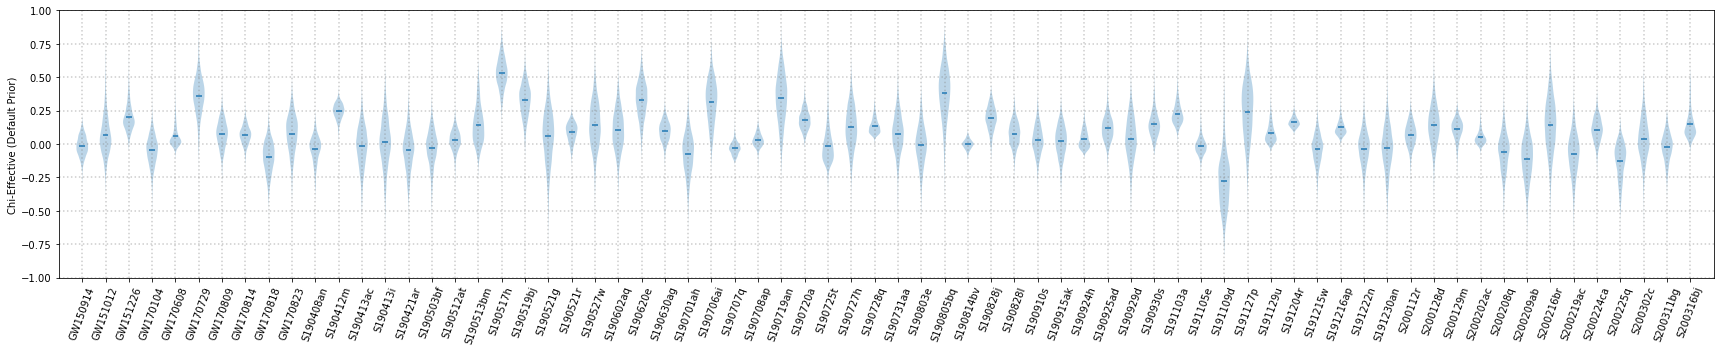

In [23]:
chi_effs = np.array([sampleDict[key]['Xeff'] for key in np.sort(list(sampleDict.keys()))])

fig,ax = plt.subplots(figsize=(24,5))
ax.violinplot(chi_effs.T,positions=np.arange(len(sampleDict)),showextrema=False,showmeans=True,)
ax.xaxis.grid(True,which='major',ls=':',color='grey',alpha=0.4,lw=1.5)
ax.yaxis.grid(True,which='major',ls=':',color='grey',alpha=0.4,lw=1.5)
ax.set_xticks(np.arange(len(sampleDict)))
ax.set_xticklabels(np.sort(list(sampleDict.keys())),rotation=70)
ax.set_xlim(-1,len(sampleDict))
ax.set_ylabel('Chi-Effective (Default Prior)')
ax.set_ylim(-1.,1.)
plt.tight_layout()
plt.savefig('spins_o3b.pdf')
plt.show()

(array([ 11.,  13.,  26.,  51.,  73., 132., 193., 246., 276., 294., 310.,
        354., 306., 390., 345., 277., 177., 139., 100.,  70.,  49.,  38.,
         32.,  28.,  23.,  19.,  18.,   6.,   2.,   2.]),
 array([-0.83131123, -0.78567253, -0.74003384, -0.69439514, -0.64875645,
        -0.60311775, -0.55747906, -0.51184036, -0.46620167, -0.42056297,
        -0.37492428, -0.32928558, -0.28364689, -0.23800819, -0.1923695 ,
        -0.1467308 , -0.10109211, -0.05545341, -0.00981472,  0.03582398,
         0.08146267,  0.12710137,  0.17274006,  0.21837876,  0.26401745,
         0.30965615,  0.35529484,  0.40093354,  0.44657223,  0.49221093,
         0.53784962]),
 <BarContainer object of 30 artists>)

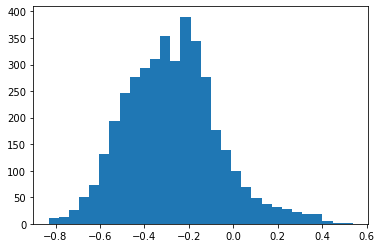

In [25]:
plt.hist(sampleDict['S191109d']['Xeff'],bins=30)

/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py37/lib/python3.7/site-packages/ipykernel/__main__.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  if __name__ == '__main__':


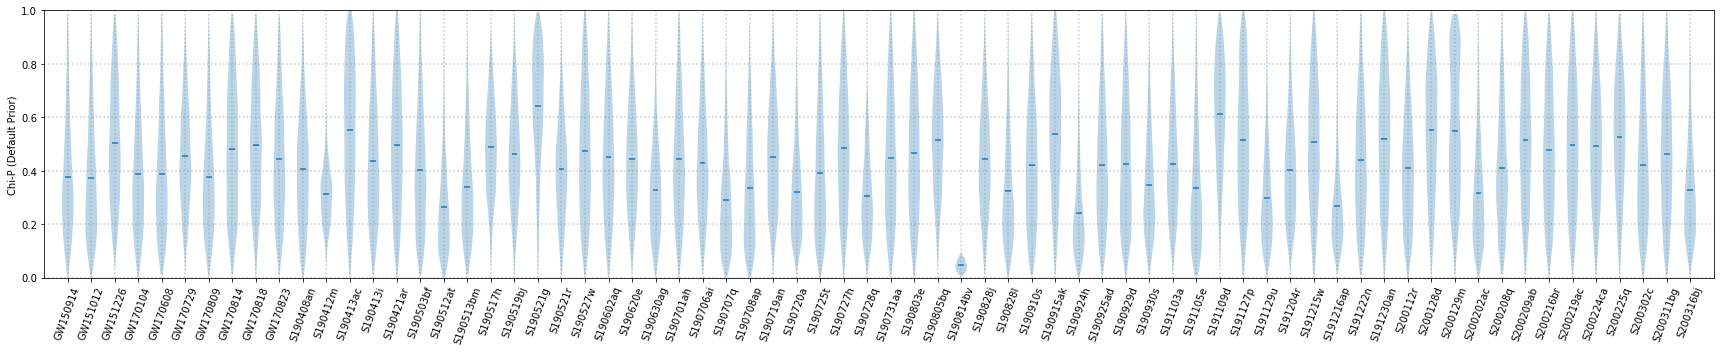

In [26]:
chi_p = np.array([sampleDict[key]['Xp'] for key in np.sort(list(sampleDict.keys()))])

fig,ax = plt.subplots(figsize=(24,5))
ax.violinplot(chi_p.T,positions=np.arange(len(sampleDict)),showextrema=False,showmeans=True,)
ax.xaxis.grid(True,which='major',ls=':',color='grey',alpha=0.4,lw=1.5)
ax.yaxis.grid(True,which='major',ls=':',color='grey',alpha=0.4,lw=1.5)
ax.set_xticks(np.arange(len(sampleDict)))
ax.set_xticklabels(np.sort(list(sampleDict.keys())),rotation=70)
ax.set_xlim(-1,len(sampleDict))
ax.set_ylabel('Chi-P (Default Prior)')
ax.set_ylim(0.,1.)
plt.tight_layout()
plt.savefig('spins_o3b_chiP.pdf')
plt.show()

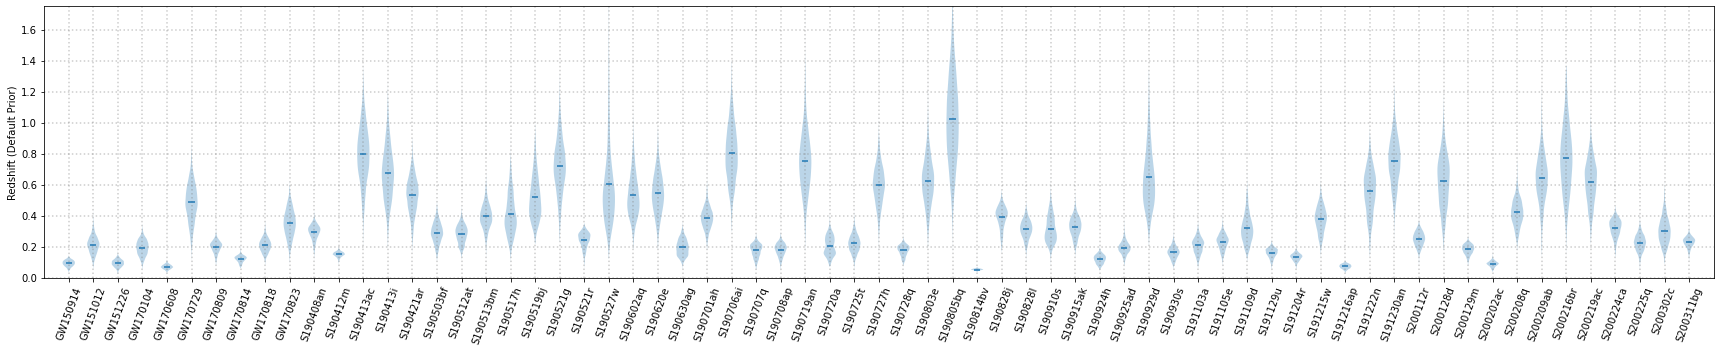

In [22]:
sampleDict = np.load('sampleDict_FAR_1_in_1_yr_08-26.pickle','r',allow_pickle=True)
zs = np.array([sampleDict[key]['z'] for key in np.sort(list(sampleDict.keys()))])

fig,ax = plt.subplots(figsize=(24,5))
ax.violinplot(zs.T,positions=np.arange(len(sampleDict)),showextrema=False,showmeans=True,)
ax.xaxis.grid(True,which='major',ls=':',color='grey',alpha=0.4,lw=1.5)
ax.yaxis.grid(True,which='major',ls=':',color='grey',alpha=0.4,lw=1.5)
ax.set_xticks(np.arange(len(sampleDict)))
ax.set_xticklabels(np.sort(list(sampleDict.keys())),rotation=70)
ax.set_xlim(-1,len(sampleDict))
ax.set_ylabel('Redshift (Default Prior)')
ax.set_ylim(0.,1.75)
plt.tight_layout()
plt.savefig('zs.pdf')
plt.show()

In [2]:
sampleDict = np.load("sampleDict_FAR_1_in_1_yr_11-29.pickle",
                       allow_pickle=True)

In [3]:
sampleDict.keys()

dict_keys(['GW150914', 'GW151012', 'GW151226', 'GW170104', 'GW170608', 'GW170729', 'GW170809', 'GW170814', 'GW170818', 'GW170823', 'S190408an', 'S190412m', 'S190413ac', 'S190413i', 'S190421ar', 'S190503bf', 'S190512at', 'S190513bm', 'S190517h', 'S190519bj', 'S190521g', 'S190521r', 'S190527w', 'S190602aq', 'S190620e', 'S190630ag', 'S190701ah', 'S190706ai', 'S190707q', 'S190708ap', 'S190719an', 'S190720a', 'S190725t', 'S190727h', 'S190728q', 'S190731aa', 'S190803e', 'S190805bq', 'S190814bv', 'S190828j', 'S190828l', 'S190910s', 'S190915ak', 'S190924h', 'S190925ad', 'S190929d', 'S190930s', 'S191103a', 'S191105e', 'S191109d', 'S191127p', 'S191129u', 'S191204r', 'S191215w', 'S191216ap', 'S191222n', 'S191230an', 'S200112r', 'S200128d', 'S200129m', 'S200202ac', 'S200208q', 'S200209ab', 'S200216br', 'S200219ac', 'S200224ca', 'S200225q', 'S200302c', 'S200311bg', 'S200316bj'])

In [4]:
sampleDict['S190719an']['m2']

array([30.40276523, 18.01028072, 21.46195598, ..., 20.63392376,
       17.07232005, 16.55803652])

In [16]:
sampleDict = np.load("sampleDict_FAR_1_in_1_yr_11-29.pickle",
                       allow_pickle=True)
oldSampleDict = np.load("/home/thomas.callister/Simona/o3a-spin-studies/Preprocessing/sampleDict_sampleRelease-conditionalAnalyticPriors.pickle",
                       allow_pickle=True)

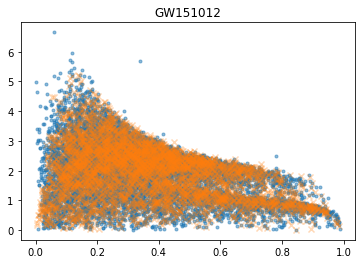

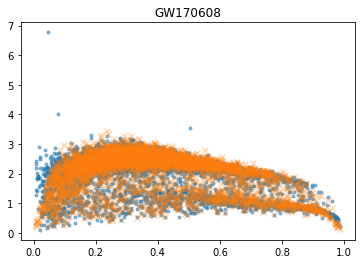

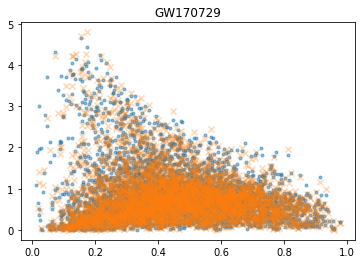

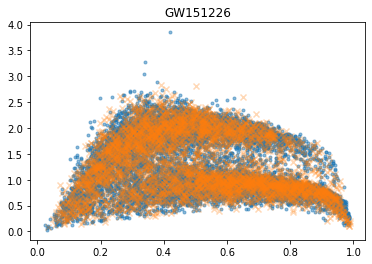

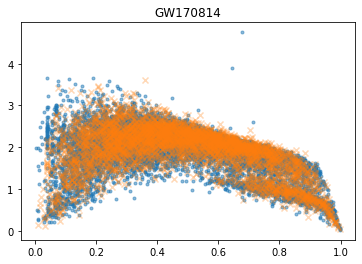

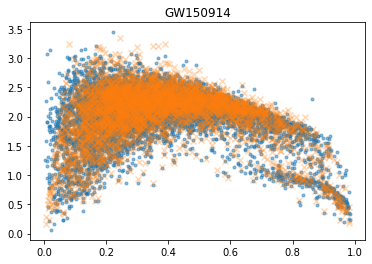

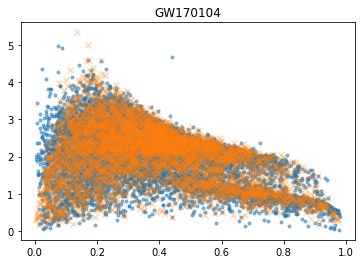

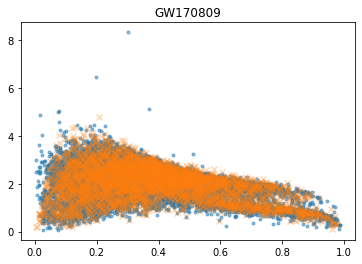

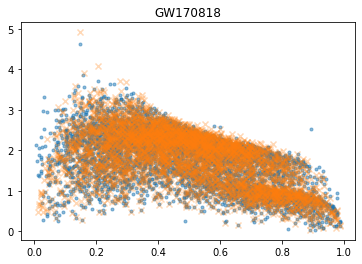

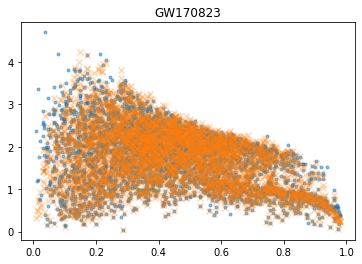

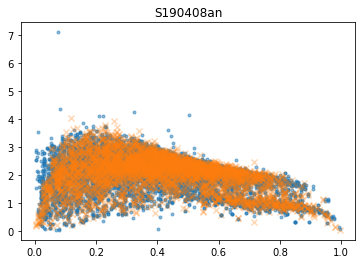

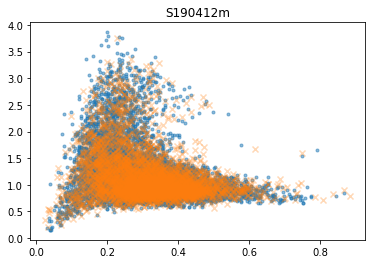

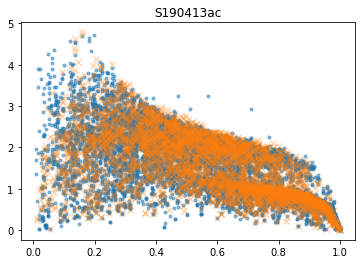

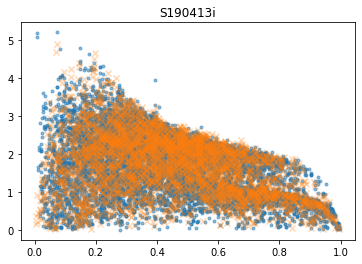

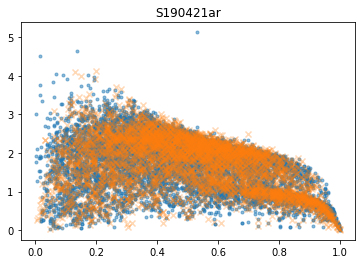

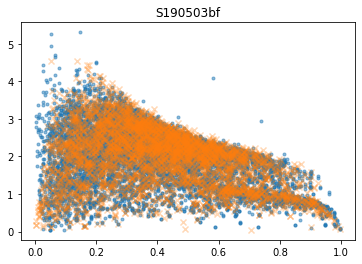

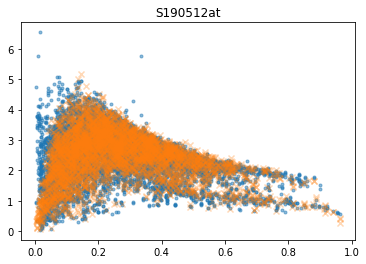

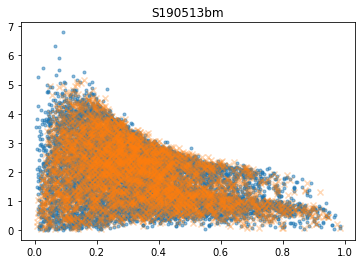

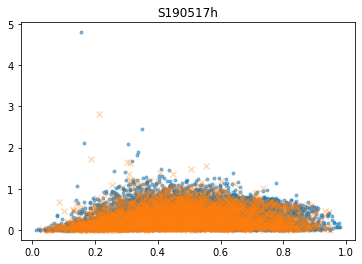

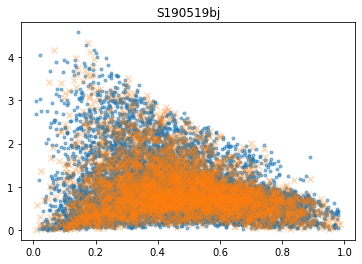

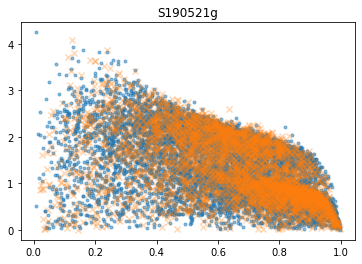

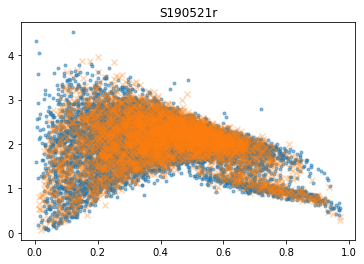

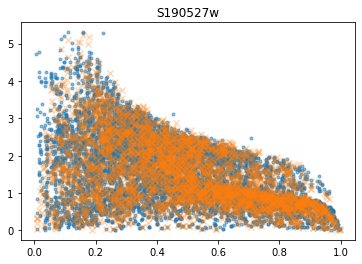

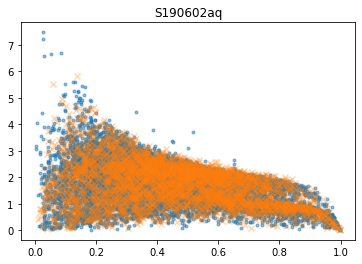

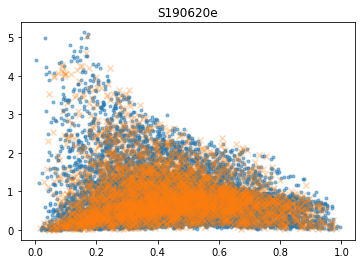

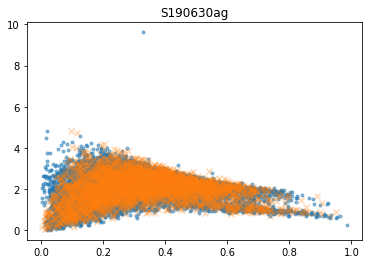

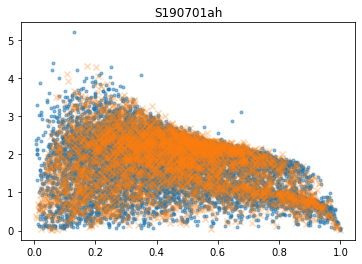

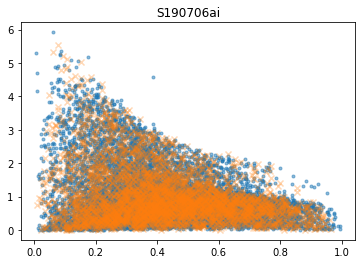

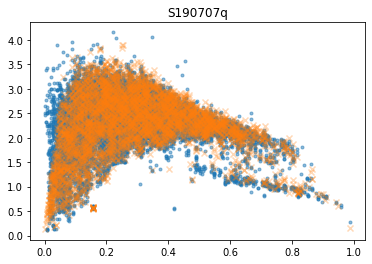

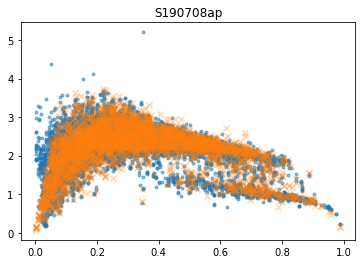

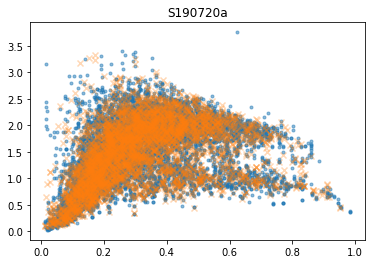

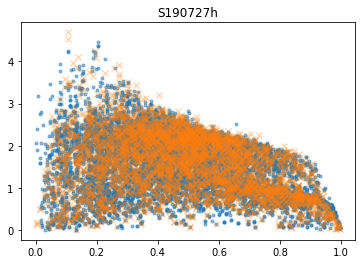

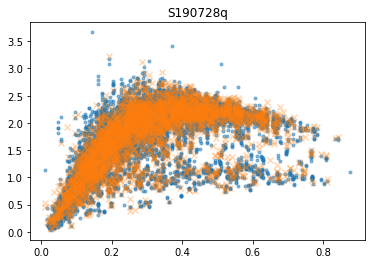

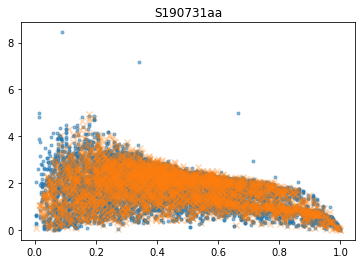

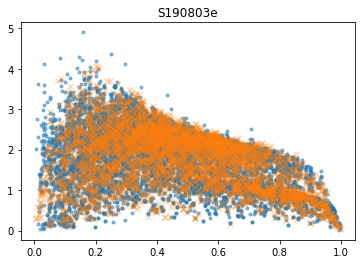

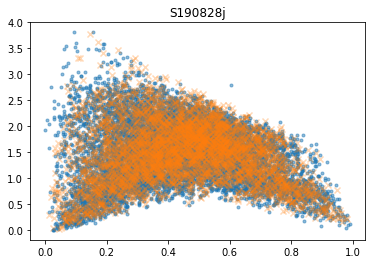

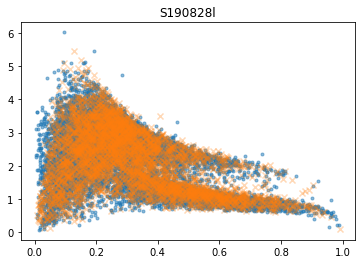

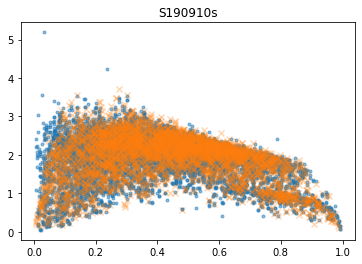

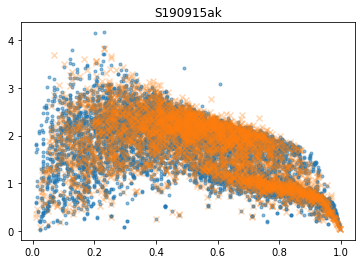

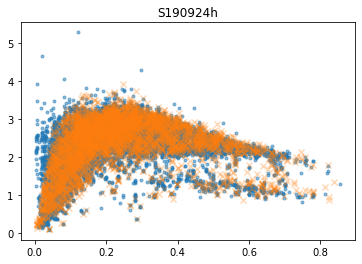

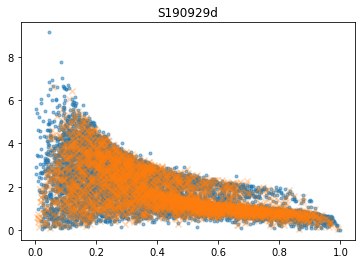

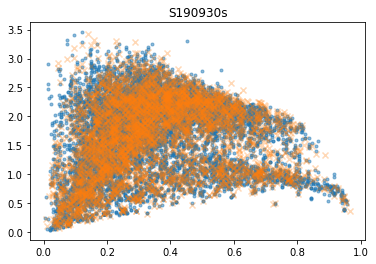

In [17]:
for key in oldSampleDict.keys():
    if key in sampleDict.keys():
        
        """
        fig,ax = plt.subplots()
        ax.hist(oldSampleDict[key]['Xp'],density=True,bins=30)
        ax.hist(sampleDict[key]['Xp'],density=True,bins=30,alpha=0.3)
        ax.set_title(key)
        plt.show()
        """
        
        fig,ax = plt.subplots()
        ax.scatter(oldSampleDict[key]['Xp'],oldSampleDict[key]['joint_priors'],
                  marker='.',alpha=0.5)
        ax.scatter(sampleDict[key]['Xp'],sampleDict[key]['joint_priors'],
                  marker='x',alpha=0.3)
        ax.set_title(key)
        plt.show()